# GSoC 2024 ML4SCI QML-HEP Tasks
**Diaz Lievano Lazaro Raul**

## Task II: Classical Graph Neural Network (GNN)

**Task description:**

For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description.
https://zenodo.org/records/3164691#.YigdGt9MHrB

* Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.

* Discuss the resulting performance of the 2 chosen architectures.

For this task we will use torch geometric, a specialized package for graphs developed by Pytorch.

In [1]:
%%capture
pip install torch_geometric


**Dataset Description:**

Two datasets of quark and gluon jets generated with Pythia 8, one with all kinematically realizable quark jets and one that excludes charm and bottom quark jets (at the level of the hard process). The one without c and b jets was originally used in Energy Flow Networks: Deep Sets for Particle Jets. Generation parameters are listed below:

Pythia 8.226 (without bc jets), Pythia 8.235 (with bc jets), s√=14TeV
Quarks from WeakBosonAndParton:qg2gmZq, gluons from WeakBosonAndParton:qqbar2gmZg with the Z decaying to neutrinos
FastJet 3.3.0, anti-ki jets with R=0.4
$pjetT∈[500,550]GeV$, $|yjet|<1.7$

There are 20 files in each dataset, each in compressed NumPy format. Files including charm and bottom jets have 'withbc' in their filename. There are two arrays in each file

X: (100000,M,4), exactly 50k quark and 50k gluon jets, randomly sorted, where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles), and the features of each particle are its pt, rapidity, azimuthal angle, and pdgid.

y: (100000,), an array of labels for the jets where gluon is 0 and quark is 1.

## load packages

In [17]:
import numpy as np
import pandas as pd
import networkx as nx

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
import torch_geometric.utils as utils
from torch_geometric.utils.convert import from_networkx
from torch_geometric.utils import to_networkx

from torch.nn import Linear
import torch_geometric.nn as geom_nn

from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import to_undirected


## Introduction to Graphs and Graph Models in PyTorch Geometric
### Graphs: Basic Concepts
Graphs are fundamental mathematical structures employed to represent relationships among entities. They comprise:

* **Nodes**: These represent entities within the graph.
* **Edges**: These denote connections between the nodes.

These connections can possess additional **attributes** like **weight or direction**, enabling the representation of diverse and intricate relationships.


Furthermore, there are **homogeneous graphs** where all nodes belong to the same category, and each node relates equally to other nodes. On the other hand, **heterogeneous graphs** consist of different kinds of nodes that differ in the ways they relate to others.

* In a homogeneous graph, all nodes belong to the same category and relate to each other uniformly. A simple example would be a social network where all nodes represent users, and all relationships between users are of the same type, such as "friendship." Each user (node) can have connections (edges) to other users, and all these connections are considered to be of the same type, i.e., friendship.

* In a heterogeneous graph, there are different types of nodes that relate in different ways. An example would be a bibliographic database where nodes can represent different types of entities such as authors, articles, and conferences. Authors may have relationships with the articles they have written, while articles may have relationships with the conferences they were presented in. Each type of node has distinct relationships with other types of nodes, making the graph heterogeneous.


### Torch Geometric: A Graph Learning Library
PyTorch Geometric serves as a specialized deep learning library, extending PyTorch's capabilities to facilitate learning on graphs and high-dimensional data. It equips users with efficient tools for manipulating graph data, streamlining the construction, and training of graph-based models.

### Graph Models in Torch Geometric
Graph models within Torch Geometric are neural networks meticulously designed for processing graph-structured data. These models possess the ability to autonomously discern intricate patterns and relationships within graph data, rendering them indispensable across various applications. Some notable applications include:

* Node Classification
* Link Prediction
* Community Detection
* Graph Classification


In this Jupyter notebook, our primary objective is to implement a Graph Neural Network tailored for **classifying Quark and Gluon events**, effectively framing it as a **graph classification task**. We leverage Graph Convolutional Neural Network layers (GCNConv) to scrutinize the structural nuances present within the graph dataset.

## Data processing



### Particle net dataset
Each event in the ParticleNet dataset contains a jet with 139 particles, each with 4 features:
* Transverse Momentum $pt$
* rapidity $\eta$
* azimuthal angle $\phi$
* Particle Data Group ID (pdgid)

Additionally, each jet has a label with the corresponding classification: 0 for gluon and 1 for quark.


### Conversion to Graph Model
To convert this tabular data into a graph model, the following was considered:

* Particles that contained no information, i.e., vectors of zeros, were filtered out.

* **Each particle is a node**, and the intrinsic characteristics of the particle such as transverse momentum $pt$ and pdgID are **node attributes**.

* The **graph is fully connected**, meaning there is an edge between every pair of particles. Additionally, the edges are **undirected** because there is no reason to believe that the connection between particles only occurs in one direction.

* Regarding rapidity and azimuthal angle, a distance in the $\eta \,vs\,
\phi$ space was calculated and used as an **edge attribute** between those two particles.

In [47]:
def distance_n_phi(rap1, rap2, phi1, phi2):
    """Calculate distance in rapidity and azimuthal angle space."""
    return ((rap2 - rap1)**2 + (phi2 - phi1)**2)**0.5

def event_to_graph(x, label):
    """Convert event data to a graph representation."""
    # Convert input to pandas DataFrame
    particles = pd.DataFrame(x, columns=["Pt", "rapidity", "azimuthal_angle", "pdgid"])
    # Filter out rows with all zeros
    particles = particles.loc[(particles != 0).any(axis=1)]

    edges = []
    nodes = []
    # Create nodes from particle data
    for i in range(len(particles)):
        node_attr = [particles.iloc[i, 0], particles.iloc[i, 3]]
        nodes.append(node_attr)
        for j in range(len(particles)):
            if i != j:
                edge = [i, j] if i < j else [j, i]
                edges.append(edge)

    weights = []
    # Calculate edge weights based on distance in rapidity and azimuthal angle space
    for i, j in edges:
        weight = distance_n_phi(particles.iloc[i, 1], particles.iloc[j, 1], particles.iloc[i, 2], particles.iloc[j, 2])
        weights.append(weight)

    # Convert data to numpy arrays
    nodes = np.array(nodes)
    edges = np.array(edges).T
    weights_np = np.round(np.array(weights) * 10)

    # Convert data to PyTorch tensors
    y = torch.tensor([label], dtype=torch.long)
    x = torch.tensor(nodes, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long)

    edge_attr = torch.tensor(weights_np, dtype=torch.float)
    edge_attr = edge_attr.unsqueeze(1)

    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    # Ensure undirected edges
    data.edge_index = to_undirected(data.edge_index)

    return data


This class CustomDataset is a custom dataset class inheriting from torch.utils.data.Dataset. It's designed to wrap a list of data items and provide a way to access them in a way that's compatible with PyTorch data loaders.

In [48]:
class CustomDataset(Dataset):
    def __init__(self, data_list):
        """Custom dataset class constructor."""
        super(CustomDataset, self).__init__()
        self.data_list = data_list

    def __len__(self):
        """Override method to return the length of the dataset."""
        return len(self.data_list)

    def __getitem__(self, idx):
        """Override method to get item by index."""
        return self.data_list[idx]


## graph dataset

For simplicity, we will take a sample from the dataset.


In [98]:

# Number of events
n = 4179
graph_dataset = []

with np.load('QG_jets.npz') as data:
    X = data['X']
    Y = data["y"]

# Iterate over each event
for event in range(n):
    # Convert event data (X) and label (Y) to a graph representation
    graph = event_to_graph(X[event], Y[event])
    # Append the graph representation to the list
    graph_dataset.append(graph)

# Create a custom dataset using the list of graph datasets
graph_dataset = CustomDataset(graph_dataset)

We can analyze the data from the first graph and create a visual representation of it. From our analysis, we have identified 18 nodes, which represents 18 particles. As it is a fully connected graph, it has 153 edges. However, since it also has undirected edges, the total number of edges in the graph is 306 (i.e. 153 x 2).

This graph illustrates a simulation of a jet, represented as a cloud of particles.

In [53]:
graph_dataset = CustomDataset(graph_dataset)
graph_dataset

CustomDataset(4179)

In [54]:
# Get the first graph from the graph dataset
graph_data = graph_dataset[0]

# Print information about the graph
graph_data

Data(x=[18, 2], edge_index=[2, 306], edge_attr=[306, 1], y=[1])

In [55]:
#information about the first graph in the dataset
print(f'Number of nodes: {graph_data.num_nodes}')
print(f'Number of edges: {graph_data.num_edges}')
print(f'Average node degree: {graph_data.num_edges / graph_data.num_nodes:.2f}')
print(f'Has isolated nodes: {graph_data.has_isolated_nodes()}')
print(f'Has self-loops: {graph_data.has_self_loops()}')
print(f'Is undirected: {graph_data.is_undirected()}')

Number of nodes: 18
Number of edges: 306
Average node degree: 17.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


tensor(1)


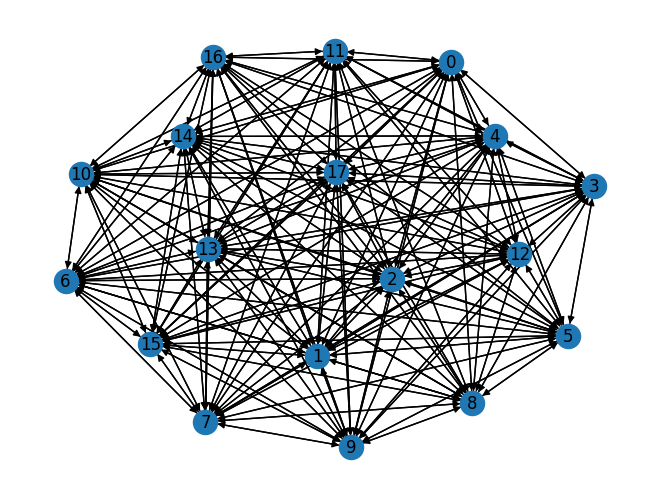

In [56]:
# convert PyTorch Geometric Data to NetworkX graph
nx_graph = to_networkx(graph_data)

# Visualize the graph
nx.draw(nx_graph, with_labels=True)

# Print the label associated with the graph.In this case, it is 1, which means that the jet corresponds to a Quark event.
print(graph_data.y[0])

In [59]:
# Shuffle the graph dataset
n = 400
# Split the dataset into training and test sets. 80 % to train and 20% to test
train_dataset = graph_dataset[:int(3000)]
test_dataset = graph_dataset[int(3000):]

# Print the number of graphs in the training and test sets
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')


Number of training graphs: 3000
Number of test graphs: 1179


In [62]:
# Initialize an empty list to store labels
lbl = []

# Iterate over each graph in the dataset
for i in range(len(graph_dataset)):
    # Append the label of each graph to the list
    lbl.append(Y[i])

# Convert the list of labels to a Pandas Series and count the occurrences of each label
label_counts = pd.Series(lbl).value_counts()

# Print the counts of each label
print(label_counts)


1.0    608
0.0    571
dtype: int64


This graph dataset is evenly distributed, so we won't have bias errors in the analysis.

## Model 1: GCNConv

### 1.

In [63]:
# Define the batch size
batch_size = 128

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Iterate over each batch in the training loader
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')  # Print the current step
    print('=======')
    # Print the number of graphs in the current batch
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    # Print the data in the current batch
    print(data)
    print()


Step 1:
Number of graphs in the current batch: 128
DataBatch(x=[5443, 2], edge_index=[2, 259850], edge_attr=[259850, 1], y=[128], batch=[5443], ptr=[129])

Step 2:
Number of graphs in the current batch: 128
DataBatch(x=[5340, 2], edge_index=[2, 256346], edge_attr=[256346, 1], y=[128], batch=[5340], ptr=[129])

Step 3:
Number of graphs in the current batch: 128
DataBatch(x=[5539, 2], edge_index=[2, 270458], edge_attr=[270458, 1], y=[128], batch=[5539], ptr=[129])

Step 4:
Number of graphs in the current batch: 128
DataBatch(x=[5916, 2], edge_index=[2, 308630], edge_attr=[308630, 1], y=[128], batch=[5916], ptr=[129])

Step 5:
Number of graphs in the current batch: 128
DataBatch(x=[5301, 2], edge_index=[2, 255122], edge_attr=[255122, 1], y=[128], batch=[5301], ptr=[129])

Step 6:
Number of graphs in the current batch: 128
DataBatch(x=[5508, 2], edge_index=[2, 270058], edge_attr=[270058, 1], y=[128], batch=[5508], ptr=[129])

Step 7:
Number of graphs in the current batch: 128
DataBatch(x=[

In [65]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        # first graph convolutional layer
        self.conv1 = GCNConv(graph_dataset.num_node_features, 128)
        # second graph convolutional layer
        self.conv2 = GCNConv(128, 128)
        # linear layer for classification
        self.lin = Linear(128, graph_dataset.num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings
        # first graph convolutional operation
        x = self.conv1(x, edge_index, edge_attr)
        # Apply ReLU activation function to introduce non-linearity
        x = F.relu(x)
        # Apply dropout regularization to prevent overfitting during training
        x = F.dropout(x, training=self.training)
        # second graph convolutional operation
        x = self.conv2(x, edge_index, edge_attr)

        # 2. Readout layer
        # Perform global mean pooling operation to aggregate node embeddings into a graph-level representation
        x = global_mean_pool(x, batch)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(2, 128)
  (conv2): GCNConv(128, 128)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)


In [66]:
# Instantiate the GCN model
model = GCN()

# Define the number of epochs and learning rate
epochs = 25
lr = 0.1

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Iterate over epochs for training
for i in range(epochs):
    # Adjust learning rate based on epoch number
    if epochs < 15:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr*0.1)

# Define the training function
def train():
    model.train()

    for data in train_loader:
        # Perform forward pass
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        # Calculate loss
        loss = criterion(out, data.y)
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()
        # Clear gradients
        optimizer.zero_grad()

# Define the testing function
def test(loader):
    model.eval()

    correct = 0
    # Iterate over data in loader
    for data in loader:
        # Perform forward pass
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        # Get predictions
        pred = out.argmax(dim=1)
        # Count correct predictions
        correct += int((pred == data.y).sum())
    # Calculate accuracy
    return correct / len(loader.dataset)

# Lists to store train and test accuracies
train_accuracy = []
test_accuracy = []

# Iterate over epochs for training and testing
for epoch in range(1, epochs):
    # Train the model
    train()
    # Evaluate train and test accuracy
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    # Append accuracies to lists
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    # Print epoch number and accuracies
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {test_acc:.4f}')


Epoch: 001, Train Acc: 0.5360, Val Acc: 0.5276
Epoch: 002, Train Acc: 0.6593, Val Acc: 0.6556
Epoch: 003, Train Acc: 0.7500, Val Acc: 0.7193
Epoch: 004, Train Acc: 0.7503, Val Acc: 0.7506
Epoch: 005, Train Acc: 0.7627, Val Acc: 0.7388
Epoch: 006, Train Acc: 0.7467, Val Acc: 0.7523
Epoch: 007, Train Acc: 0.7657, Val Acc: 0.7557
Epoch: 008, Train Acc: 0.7747, Val Acc: 0.7642
Epoch: 009, Train Acc: 0.7733, Val Acc: 0.7591
Epoch: 010, Train Acc: 0.7633, Val Acc: 0.7540
Epoch: 011, Train Acc: 0.7630, Val Acc: 0.7812
Epoch: 012, Train Acc: 0.7640, Val Acc: 0.7617
Epoch: 013, Train Acc: 0.7693, Val Acc: 0.7625
Epoch: 014, Train Acc: 0.7630, Val Acc: 0.7795
Epoch: 015, Train Acc: 0.7730, Val Acc: 0.7523
Epoch: 016, Train Acc: 0.7577, Val Acc: 0.7676
Epoch: 017, Train Acc: 0.7737, Val Acc: 0.7735
Epoch: 018, Train Acc: 0.7650, Val Acc: 0.7820
Epoch: 019, Train Acc: 0.7633, Val Acc: 0.7549
Epoch: 020, Train Acc: 0.7543, Val Acc: 0.7566
Epoch: 021, Train Acc: 0.7733, Val Acc: 0.7795
Epoch: 022, T

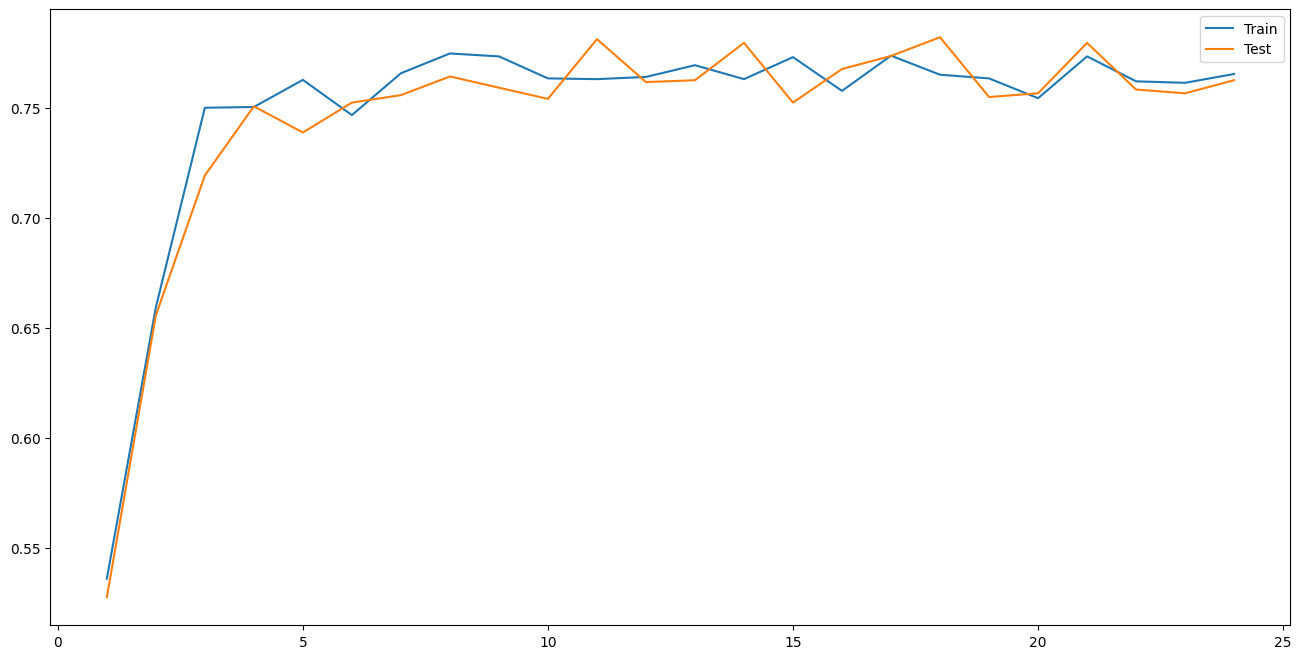

In [67]:
# Set the figure size
plt.figure(figsize=(16, 8))

# Plot train accuracy over epochs
plt.plot(range(1, epochs), train_accuracy, label="Train")
# Plot test accuracy over epochs
plt.plot(range(1, epochs), test_accuracy, label="Test")

plt.legend()
plt.show()

In [68]:
#Save the model and the optimizer
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy
}, 'modelo_entrenado.tar')


### 2

In [ ]:
# Define the batch size
batch_size = 32

# Create data loaders for the training and test datasets
train_loader2 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader2 = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class GCN2(torch.nn.Module):
    def __init__(self):
        super(GCN2, self).__init__()
        #torch.manual_seed(12345)
        self.conv1 = GCNConv(graph_dataset.num_node_features, 32)
        self.conv2 = GCNConv(32, 32)
        self.conv3 = GCNConv(32, 32)
        self.lin = Linear(32, graph_dataset.num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x= F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index, edge_attr)
        # 2. Readout layer
        x = global_mean_pool(x, batch)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

model2 = GCN2()
print(model2)

GCN2(
  (conv1): GCNConv(2, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)


In the second model, I endeavored to train a Graph Neural Network (GNN) utilizing Gated Graph Attention Network (GATConv) layers. However, I encountered challenges during the training process. Consequently, I made the decision to switch to an alternative GNN architecture, employing a model with more Graph Convolutional Network (GCNConv) layers instead and changing the hidden channels.

In [ ]:
# Instantiate the GCN2 model
model2 = GCN2()

# Define the number of epochs and learning rate
epochs = 25
lr = 0.1

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Iterate over epochs for training
for i in range(epochs):
    # Adjust learning rate based on epoch number
    if epochs < 15:
        optimizer = torch.optim.Adam(model2.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model2.parameters(), lr=lr*0.1)

# Define the training function
def train():
    model2.train()

    # Iterate over data in the train loader
    for data in train_loader2:
        # Perform forward pass
        out = model2(data.x, data.edge_index, data.edge_attr, data.batch)
        # Calculate loss
        loss = criterion(out, data.y)
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()
        # Clear gradients
        optimizer.zero_grad()

# Define the testing function
def test(loader):
    model2.eval()

    correct = 0
    # Iterate over data in the loader
    for data in loader:
        # Perform forward pass
        out = model2(data.x, data.edge_index, data.edge_attr, data.batch)
        # Get predictions
        pred = out.argmax(dim=1)
        # Count correct predictions
        correct += int((pred == data.y).sum())
    # Calculate accuracy
    return correct / len(loader.dataset)

# Lists to store train and test accuracies
train_accuracy2 = []
test_accuracy2 = []

# Iterate over epochs for training and testing
for epoch in range(1, epochs):
    # Train the model
    train()
    # Evaluate train and test accuracy
    train_acc = test(train_loader2)
    test_acc = test(test_loader2)
    # Append accuracies to lists
    train_accuracy2.append(train_acc)
    test_accuracy2.append(test_acc)
    # Print epoch number and accuracies
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5250, Val Acc: 0.5100
Epoch: 002, Train Acc: 0.5575, Val Acc: 0.5550
Epoch: 003, Train Acc: 0.6450, Val Acc: 0.6250
Epoch: 004, Train Acc: 0.5800, Val Acc: 0.5400
Epoch: 005, Train Acc: 0.7350, Val Acc: 0.7400
Epoch: 006, Train Acc: 0.7525, Val Acc: 0.7100
Epoch: 007, Train Acc: 0.7538, Val Acc: 0.7550
Epoch: 008, Train Acc: 0.7225, Val Acc: 0.7250
Epoch: 009, Train Acc: 0.7500, Val Acc: 0.7100
Epoch: 010, Train Acc: 0.7688, Val Acc: 0.7350
Epoch: 011, Train Acc: 0.7475, Val Acc: 0.7550
Epoch: 012, Train Acc: 0.7238, Val Acc: 0.7150
Epoch: 013, Train Acc: 0.7800, Val Acc: 0.7450
Epoch: 014, Train Acc: 0.7425, Val Acc: 0.7400
Epoch: 015, Train Acc: 0.7750, Val Acc: 0.7450
Epoch: 016, Train Acc: 0.7438, Val Acc: 0.7550
Epoch: 017, Train Acc: 0.7738, Val Acc: 0.7500
Epoch: 018, Train Acc: 0.7150, Val Acc: 0.7250
Epoch: 019, Train Acc: 0.7775, Val Acc: 0.7400
Epoch: 020, Train Acc: 0.7488, Val Acc: 0.7450
Epoch: 021, Train Acc: 0.6775, Val Acc: 0.6750
Epoch: 022, T

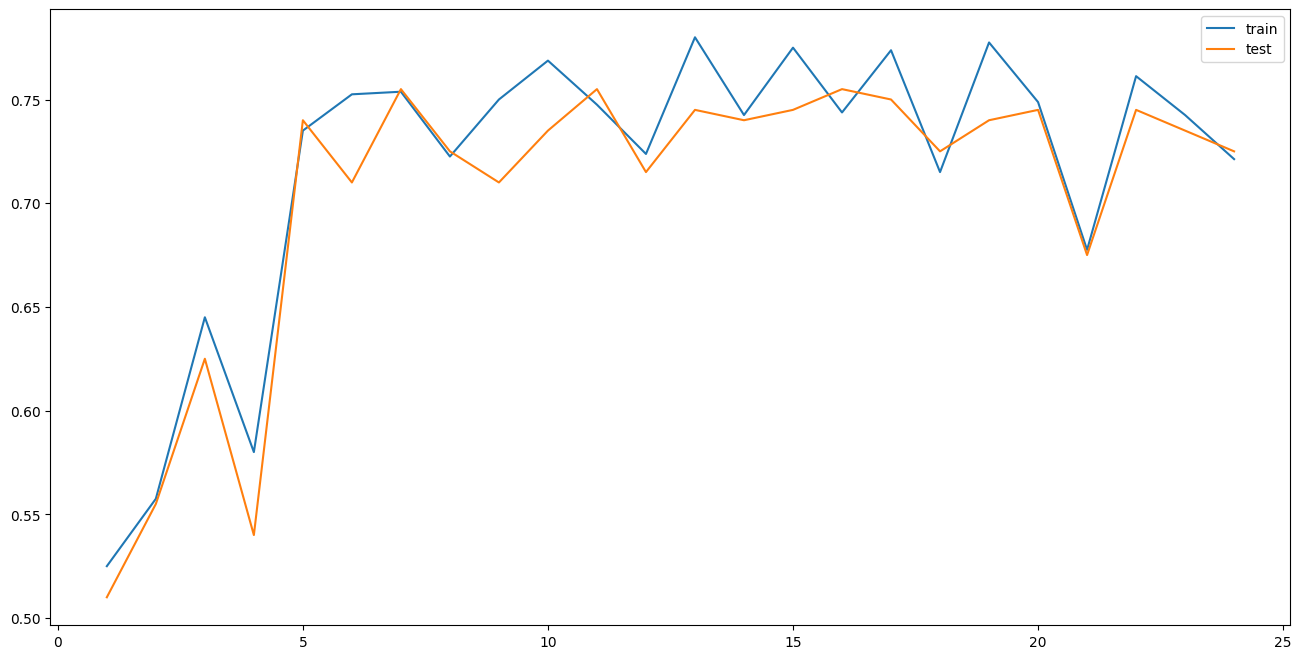

In [ ]:
# Set the figure size
plt.figure(figsize=(16, 8))

# Plot train accuracy over epochs
plt.plot(range(1, epochs), train_accuracy2, label="Train")

# Plot test accuracy over epochs
plt.plot(range(1, epochs), test_accuracy2, label="Test")

plt.legend()
plt.show()

For both models, we can see a similar performance

## Model 2: GraphConv

In [96]:
class GCN2(torch.nn.Module):
  def __init__(self):
    super(GCN2, self).__init__()
    #torch.manual_seed(12345)
    self.conv1 = GraphConv(graph_dataset.num_node_features, 128)
    self.conv2 = GraphConv(128, 128)
    self.conv3 = GraphConv(128, 128)
    self.lin = Linear(128, graph_dataset.num_classes)

  def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings
    x = self.conv1(x, edge_index, edge_attr)
    x = F.relu(x)
    x= F.dropout(x, training=self.training)
    x = self.conv2(x, edge_index, edge_attr)
    x = F.dropout(x, training=self.training)
    x = self.conv3(x, edge_index, edge_attr)
        # 2. Readout layer
    x = global_mean_pool(x, batch)

        # 3. Apply a final classifier
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.lin(x)

    return F.log_softmax(x, dim=1)

model2 = GCN2()
print(model2)

GCN2(
  (conv1): GraphConv(2, 128)
  (conv2): GraphConv(128, 128)
  (conv3): GraphConv(128, 128)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)


In [97]:
# Instantiate the GCN2 model
model2 = GCN2()

# Define the number of epochs and learning rate
epochs = 25
lr = 0.01

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Iterate over epochs for training
for i in range(epochs):
    # Adjust learning rate based on epoch number
    if epochs < 15:
        optimizer = torch.optim.Adam(model2.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model2.parameters(), lr=lr*0.1)

# Define the training function
def train():
    model2.train()

    # Iterate over data in the train loader
    for data in train_loader:
        # Perform forward pass
        out = model2(data.x, data.edge_index, data.edge_attr, data.batch)
        # Calculate loss
        loss = criterion(out, data.y)
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()
        # Clear gradients
        optimizer.zero_grad()

# Define the testing function
def test(loader):
    model2.eval()

    correct = 0
    # Iterate over data in the loader
    for data in loader:
        # Perform forward pass
        out = model2(data.x, data.edge_index, data.edge_attr, data.batch)
        # Get predictions
        pred = out.argmax(dim=1)
        # Count correct predictions
        correct += int((pred == data.y).sum())
    # Calculate accuracy
    return correct / len(loader.dataset)

# Lists to store train and test accuracies
train_accuracy2 = []
test_accuracy2 = []

# Iterate over epochs for training and testing
for epoch in range(1, epochs):
    # Train the model
    train()
    # Evaluate train and test accuracy
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    # Append accuracies to lists
    train_accuracy2.append(train_acc)
    test_accuracy2.append(test_acc)
    # Print epoch number and accuracies
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5363, Val Acc: 0.5301
Epoch: 002, Train Acc: 0.4980, Val Acc: 0.4902
Epoch: 003, Train Acc: 0.5220, Val Acc: 0.5131
Epoch: 004, Train Acc: 0.5217, Val Acc: 0.5098
Epoch: 005, Train Acc: 0.5483, Val Acc: 0.5573
Epoch: 006, Train Acc: 0.5413, Val Acc: 0.5310
Epoch: 007, Train Acc: 0.6203, Val Acc: 0.6115
Epoch: 008, Train Acc: 0.6270, Val Acc: 0.6370
Epoch: 009, Train Acc: 0.6363, Val Acc: 0.6268
Epoch: 010, Train Acc: 0.6923, Val Acc: 0.6675
Epoch: 011, Train Acc: 0.6710, Val Acc: 0.6650
Epoch: 012, Train Acc: 0.6607, Val Acc: 0.6633
Epoch: 013, Train Acc: 0.6197, Val Acc: 0.6293
Epoch: 014, Train Acc: 0.6607, Val Acc: 0.6455
Epoch: 015, Train Acc: 0.6890, Val Acc: 0.6743
Epoch: 016, Train Acc: 0.6777, Val Acc: 0.6718
Epoch: 017, Train Acc: 0.5807, Val Acc: 0.5683
Epoch: 018, Train Acc: 0.6707, Val Acc: 0.6853
Epoch: 019, Train Acc: 0.6870, Val Acc: 0.6836
Epoch: 020, Train Acc: 0.7420, Val Acc: 0.7193
Epoch: 021, Train Acc: 0.6987, Val Acc: 0.6836
Epoch: 022, T

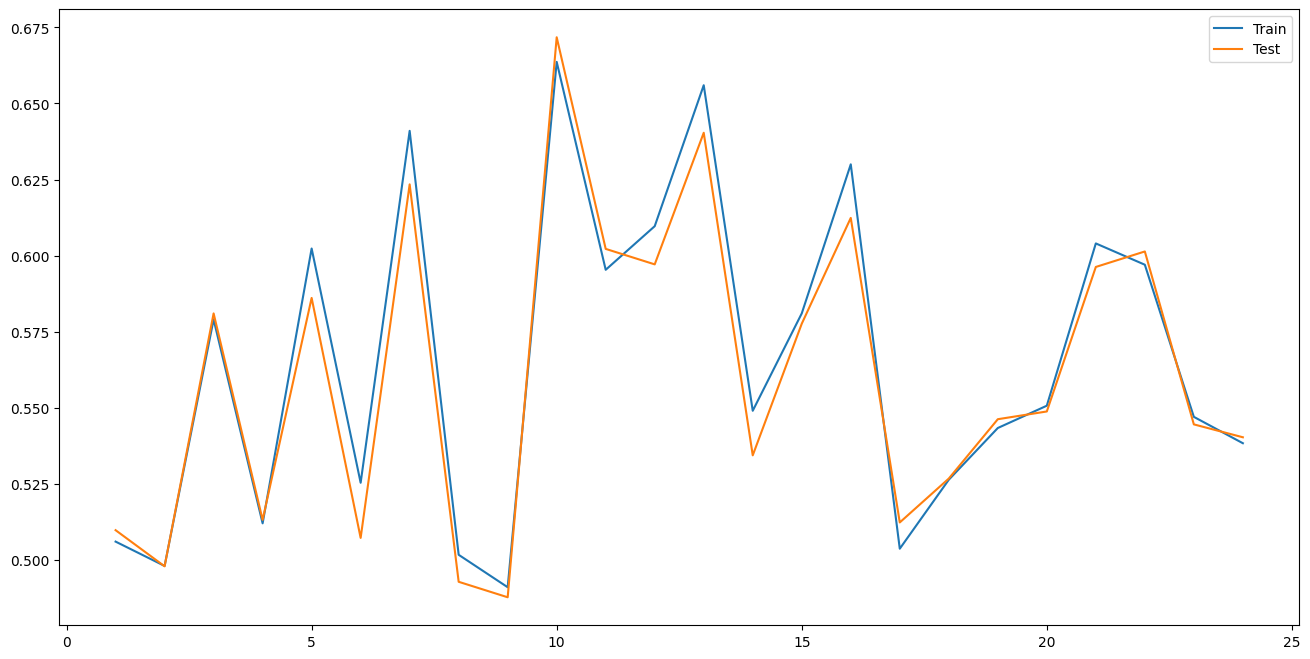

In [76]:
# Set the figure size
plt.figure(figsize=(16, 8))

# Plot train accuracy over epochs
plt.plot(range(1, epochs), train_accuracy2, label="Train")

# Plot test accuracy over epochs
plt.plot(range(1, epochs), test_accuracy2, label="Test")

plt.legend()
plt.show()

## Model 3. ChebConv

### 1.

In [77]:
from torch_geometric.nn import ChebConv

class GCN3(torch.nn.Module):
    def __init__(self):
        super(GCN3, self).__init__()
        #torch.manual_seed(12345)
        self.conv1 = ChebConv(graph_dataset.num_node_features, 64, 2)
        self.conv2 = ChebConv(64, 64, 2)
        self.conv3 = ChebConv(64, 64, 2)
        self.lin = Linear(64, graph_dataset.num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x= F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index, edge_attr)
        # 2. Readout layer
        x = global_mean_pool(x, batch)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

model3 = GCN3()
print(model3)

# Instantiate the GCN2 model
model3 = GCN3()

# Define the number of epochs and learning rate
epochs = 25
lr = 0.005

# Define the number of epochs and learning rate
#epochs = 25
#lr = 0.1

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Iterate over epochs for training
for i in range(epochs):
    # Adjust learning rate based on epoch number
    if epochs < 15:
        optimizer = torch.optim.Adam(model3.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model3.parameters(), lr=lr*0.1)

# Define the training function
def train():
    model3.train()

    # Iterate over data in the train loader
    for data in train_loader:
        # Perform forward pass
        out = model3(data.x, data.edge_index, data.edge_attr, data.batch)
        # Calculate loss
        loss = criterion(out, data.y)
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()
        # Clear gradients
        optimizer.zero_grad()

# Define the testing function
def test(loader):
    model3.eval()

    correct = 0
    # Iterate over data in the loader
    for data in loader:
        # Perform forward pass
        out = model3(data.x, data.edge_index, data.edge_attr, data.batch)
        # Get predictions
        pred = out.argmax(dim=1)
        # Count correct predictions
        correct += int((pred == data.y).sum())
    # Calculate accuracy
    return correct / len(loader.dataset)

# Lists to store train and test accuracies
train_accuracy3 = []
test_accuracy3 = []

# Iterate over epochs for training and testing
for epoch in range(1, epochs):
    # Train the model
    train()
    # Evaluate train and test accuracy
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    # Append accuracies to lists
    train_accuracy3.append(train_acc)
    test_accuracy3.append(test_acc)
    # Print epoch number and accuracies
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {test_acc:.4f}')

GCN3(
  (conv1): ChebConv(2, 64, K=2, normalization=sym)
  (conv2): ChebConv(64, 64, K=2, normalization=sym)
  (conv3): ChebConv(64, 64, K=2, normalization=sym)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)
Epoch: 001, Train Acc: 0.5217, Val Acc: 0.5377
Epoch: 002, Train Acc: 0.6813, Val Acc: 0.6819
Epoch: 003, Train Acc: 0.6517, Val Acc: 0.6573
Epoch: 004, Train Acc: 0.6650, Val Acc: 0.6751
Epoch: 005, Train Acc: 0.6933, Val Acc: 0.6870
Epoch: 006, Train Acc: 0.6773, Val Acc: 0.6701
Epoch: 007, Train Acc: 0.7017, Val Acc: 0.6921
Epoch: 008, Train Acc: 0.6890, Val Acc: 0.6811
Epoch: 009, Train Acc: 0.6950, Val Acc: 0.6913
Epoch: 010, Train Acc: 0.6973, Val Acc: 0.6836
Epoch: 011, Train Acc: 0.7060, Val Acc: 0.6913
Epoch: 012, Train Acc: 0.6580, Val Acc: 0.6565
Epoch: 013, Train Acc: 0.7043, Val Acc: 0.6904
Epoch: 014, Train Acc: 0.6987, Val Acc: 0.6887
Epoch: 015, Train Acc: 0.6973, Val Acc: 0.6836
Epoch: 016, Train Acc: 0.6943, Val Acc: 0.6794
Epoch: 017, Train Acc: 0.7

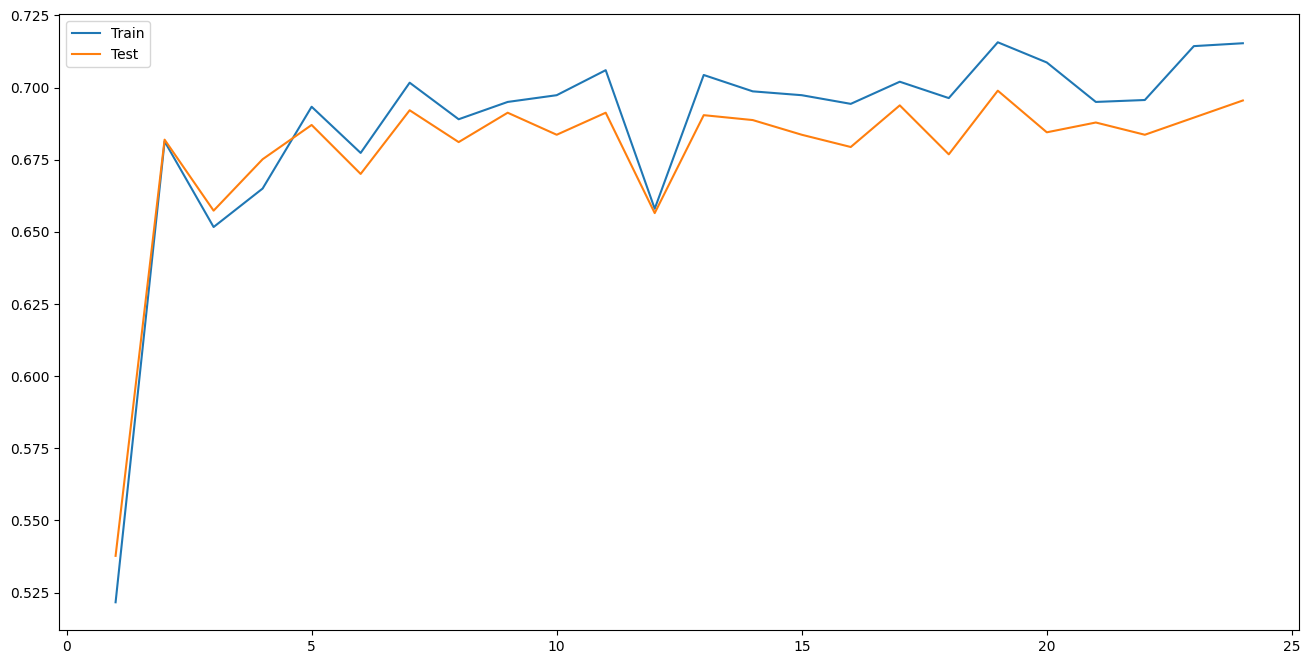

In [79]:
# Set the figure size
plt.figure(figsize=(16, 8))

# Plot train accuracy over epochs
plt.plot(range(1, epochs), train_accuracy3, label="Train")

# Plot test accuracy over epochs
plt.plot(range(1, epochs), test_accuracy3, label="Test")

plt.legend()
plt.show()

### 2.

In [80]:

class GCN3(torch.nn.Module):
    def __init__(self):
        super(GCN3, self).__init__()
        #torch.manual_seed(12345)
        self.conv1 = ChebConv(graph_dataset.num_node_features, 64, 2)
        self.conv2 = ChebConv(64, 64, 2)
        self.conv3 = ChebConv(64, 64, 2)
        self.lin = Linear(64, graph_dataset.num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x= F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index, edge_attr)
        # 2. Readout layer
        x = global_mean_pool(x, batch)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

model3 = GCN3()
print(model3)

# Instantiate the GCN2 model
model3 = GCN3()

# Define the number of epochs and learning rate
epochs = 25
#lr = 0.005

# Define the number of epochs and learning rate
#epochs = 25
lr = 0.1

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Iterate over epochs for training
for i in range(epochs):
    # Adjust learning rate based on epoch number
    if epochs < 15:
        optimizer = torch.optim.Adam(model3.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model3.parameters(), lr=lr*0.1)

# Define the training function
def train():
    model3.train()

    # Iterate over data in the train loader
    for data in train_loader:
        # Perform forward pass
        out = model3(data.x, data.edge_index, data.edge_attr, data.batch)
        # Calculate loss
        loss = criterion(out, data.y)
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()
        # Clear gradients
        optimizer.zero_grad()

# Define the testing function
def test(loader):
    model3.eval()

    correct = 0
    # Iterate over data in the loader
    for data in loader:
        # Perform forward pass
        out = model3(data.x, data.edge_index, data.edge_attr, data.batch)
        # Get predictions
        pred = out.argmax(dim=1)
        # Count correct predictions
        correct += int((pred == data.y).sum())
    # Calculate accuracy
    return correct / len(loader.dataset)

# Lists to store train and test accuracies
train_accuracy3 = []
test_accuracy3 = []

# Iterate over epochs for training and testing
for epoch in range(1, epochs):
    # Train the model
    train()
    # Evaluate train and test accuracy
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    # Append accuracies to lists
    train_accuracy3.append(train_acc)
    test_accuracy3.append(test_acc)
    # Print epoch number and accuracies
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {test_acc:.4f}')

GCN3(
  (conv1): ChebConv(2, 64, K=2, normalization=sym)
  (conv2): ChebConv(64, 64, K=2, normalization=sym)
  (conv3): ChebConv(64, 64, K=2, normalization=sym)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)
Epoch: 001, Train Acc: 0.5037, Val Acc: 0.5115
Epoch: 002, Train Acc: 0.6100, Val Acc: 0.6141
Epoch: 003, Train Acc: 0.6980, Val Acc: 0.6836
Epoch: 004, Train Acc: 0.7077, Val Acc: 0.7014
Epoch: 005, Train Acc: 0.7137, Val Acc: 0.7082
Epoch: 006, Train Acc: 0.7243, Val Acc: 0.7176
Epoch: 007, Train Acc: 0.7350, Val Acc: 0.7209
Epoch: 008, Train Acc: 0.7453, Val Acc: 0.7345
Epoch: 009, Train Acc: 0.7407, Val Acc: 0.7286
Epoch: 010, Train Acc: 0.7390, Val Acc: 0.7260
Epoch: 011, Train Acc: 0.7453, Val Acc: 0.7286
Epoch: 012, Train Acc: 0.7420, Val Acc: 0.7320
Epoch: 013, Train Acc: 0.7583, Val Acc: 0.7439
Epoch: 014, Train Acc: 0.7383, Val Acc: 0.7396
Epoch: 015, Train Acc: 0.7600, Val Acc: 0.7625
Epoch: 016, Train Acc: 0.7670, Val Acc: 0.7676
Epoch: 017, Train Acc: 0.7

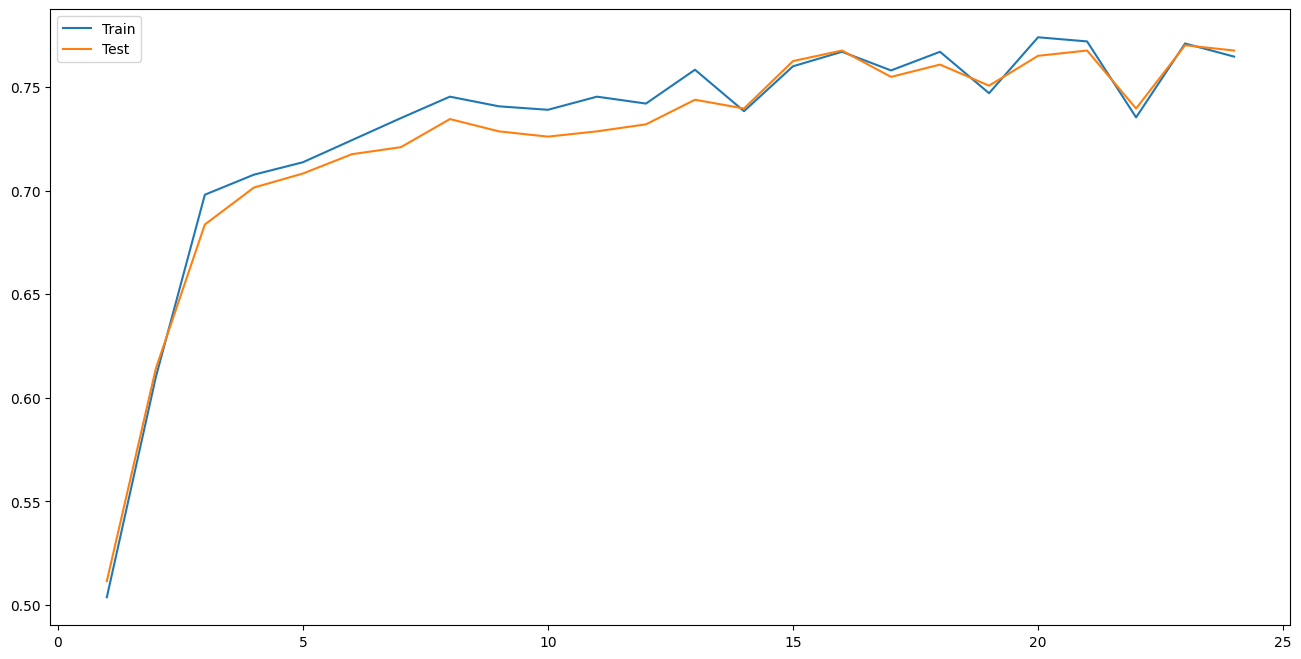

In [81]:
# Set the figure size
plt.figure(figsize=(16, 8))

# Plot train accuracy over epochs
plt.plot(range(1, epochs), train_accuracy3, label="Train")

# Plot test accuracy over epochs
plt.plot(range(1, epochs), test_accuracy3, label="Test")

plt.legend()
plt.show()

## Comparison

Here, we are going to compare the two best models: model 1 (GCNConv) and model 3 (ChebConv).

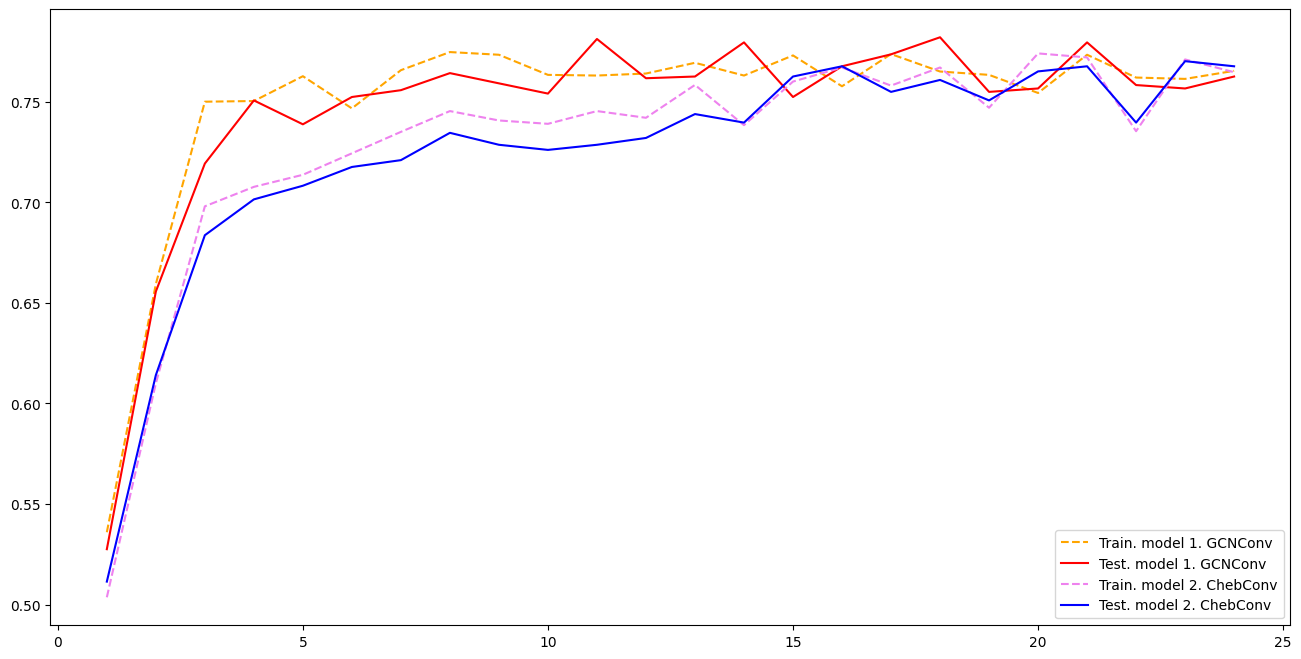

In [89]:
# Set the figure size
plt.figure(figsize=(16, 8))

# model 1. GCNConv accuracy
plt.plot(range(1, epochs), train_accuracy, label="Train. model 1. GCNConv", color = "orange", ls = "--")
plt.plot(range(1, epochs), test_accuracy, label="Test. model 1. GCNConv", color = "red" )

# model 3 ChebConv accuracy
plt.plot(range(1, epochs), train_accuracy3, label="Train. model 2. ChebConv", color = "violet", ls = "--")
plt.plot(range(1, epochs), test_accuracy3, label="Test. model 2. ChebConv", color = "blue")

plt.legend()
plt.show()

## Conclusion:

In summary, in this project we explored the application of two Graph Neural Network (GNN) models for the classification of quark/gluon jet events: one based on GCNConv and the other on ChebConv. After training both models for 25 epochs, we observed that the GCNConv-based model achieved slightly higher accuracy than the ChebConv-based model, with values of 75% and 73% respectively. Additionally, we noticed a trend where increasing the number of internal channels in the models led to an increase in classification accuracy.

Although the GCNConv-based model demonstrated slightly better performance in this scenario, there are some areas we could explore to further improve the performance of our models:

* **Hyperparameter tuning:** We could conduct a more exhaustive search for hyperparameters for both models, such as the number of internal channels, learning rate, batch size, among others, to find optimal configurations that improve performance.

* **Feature engineering:** We could explore the possibility of including additional or derived features from our input data to enrich the representation of the graphs and potentially improve classification performance. In this case, we could take into account the 4 features of the X data instead of 2.

* **Alternative model architectures:** In addition to GCNConv and ChebConv, we could investigate other GNN architectures or even combinations of multiple layers and types of convolutions to see if we can achieve additional improvements in performance increasing the complexity.

Taken together, these suggestions could help us enhance the ability of our models to classify quark/gluon jet events with greater accuracy and generalization in future research endeavors.



Reference:

[1] [PyTorch Geometric. (2024). Documentation.](https://pytorch-geometric.readthedocs.io/en/latest/)

[2] [Jonathan Shlomi, Peter Battaglia, Jean-Roch Vlimant. "Graph Neural Networks in Particle Physics" (2020)	arXiv:2007.13681 [hep-ex]](https://arxiv.org/abs/2007.13681)

[3] [Jie Zhou et Al. "Graph Neural Networks: A Review of Methods and Applications" (2018) 	arXiv:1812.08434 [cs.LG].](https://arxiv.org/abs/1812.08434)